In [1]:
import matplotlib.pyplot as plt
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *
import healpy as hp
from forse.networks.dcgan import *
from mypy import *

Using TensorFlow backend.


In [2]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/', img_size=(64, 64))

In [3]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
dcgan.generator = load_model(dir_models+'generat_99999.h5')

/global/homes/k/krach/usr/python_prefix_3.7/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/maps/'
Ls = np.load(patch_path+'patches_PySM_dust_T_nside2048_fwhm1.npy')
Ss = np.load(patch_path+'patches_PySM_dust_T_nside2048_fwhm0.12.npy')

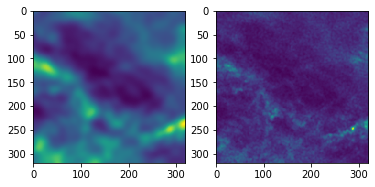

In [5]:
plt.subplot(121)
plt.imshow(Ls[80])
plt.subplot(122)
plt.imshow(Ss[80])

In [6]:
npatches = len(Ls)
npatches

288

In [7]:
Ls_zoom = np.zeros((npatches*25, 64, 64))
Ss_zoom = np.zeros((npatches*25, 64, 64))
Ls_zoom_edges = []
Ss_ratio_zoom_edges = []
for i in range(npatches):
    j = i
    Ls_zoom[i*25:(i+1)*25] = divide_image(Ls[j], 64, 64)[0]
    Ss_zoom[i*25:(i+1)*25] = divide_image(Ss[j], 64, 64)[0]
Ls_zoom_scaled = np.copy(Ls_zoom)
Ss_ratio_zoom = Ss_zoom/Ls_zoom
Ss_ratio_zoom_scaled = np.copy(Ss_ratio_zoom)
for i in range(Ls_zoom_scaled.shape[0]):
    Ls_zoom_scaled[i], Xmin, Xmax = rescale_min_max(Ls_zoom[i], return_min_max=True)
    Ls_zoom_edges.append([Xmin, Xmax])
    Ss_ratio_zoom_scaled[i], Xmin, Xmax = rescale_min_max(Ss_ratio_zoom[i], return_min_max=True)
    Ss_ratio_zoom_edges.append([Xmin, Xmax])
Ls_zoom_edges = np.array(Ls_zoom_edges) 
Ss_ratio_zoom_edges = np.array(Ss_ratio_zoom_edges) 
Ls_zoom_scaled = Ls_zoom_scaled.reshape((npatches*25, 64, 64, 1))
Ss_ratio_zoom_scaled = Ss_ratio_zoom_scaled.reshape((npatches*25, 64, 64, 1))

In [8]:
NNout = dcgan.generator.predict(Ls_zoom_scaled)

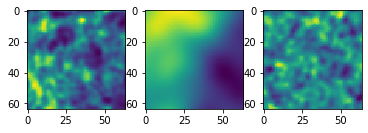

In [9]:
expl = 660
plt.subplot(131)
plt.imshow(NNout[expl,:,:,0])
plt.subplot(132)
plt.imshow(Ls_zoom_scaled[expl,:,:,0])
plt.subplot(133)
plt.imshow(Ss_ratio_zoom_scaled[expl,:,:,0])

In [10]:
NNout_normed = np.copy(NNout)
for i in range(len(NNout)):
    NNout_normed[i] = (
        rescale_min_max_back(NNout[i], 
        [(Ss_ratio_zoom_edges[i,0]), (Ss_ratio_zoom_edges[i,1])]))

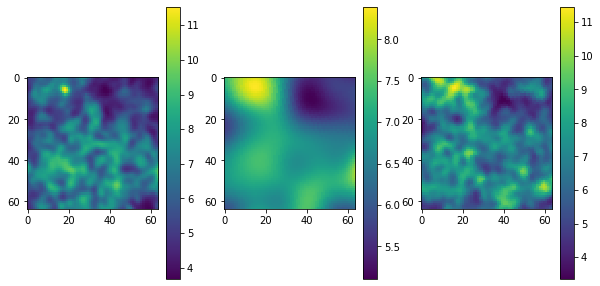

In [11]:
expl = 665
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(NNout_normed[expl,:,:,0]*Ls_zoom[expl])
plt.colorbar()
plt.subplot(132)
plt.imshow(Ls_zoom[expl])
plt.colorbar()
plt.subplot(133)
plt.imshow(Ss_ratio_zoom[expl]*Ls_zoom[expl])
plt.colorbar()

In [12]:
NN_Ss = []
for im in range(npatches):
    Ls_zoom_oversamp = divide_image(Ls[im], 32, 64)
    Ss_ratio_zoom_oversamp = divide_image(Ss[im]/Ls[im], 32, 64)
    Ls_zoom_oversamp_scaled = np.copy(Ls_zoom_oversamp[0])
    Ss_ratio_zoom_oversamp_scaled = np.copy(Ss_ratio_zoom_oversamp[0])
    Xmin = np.zeros(Ls_zoom_oversamp_scaled.shape[0])
    Xmax = np.zeros(Ls_zoom_oversamp_scaled.shape[0])
    for i in range(Ls_zoom_oversamp_scaled.shape[0]):
        Ls_zoom_oversamp_scaled[i] = rescale_min_max(Ls_zoom_oversamp_scaled[i])
        Ss_ratio_zoom_oversamp_scaled[i], Xmin[i], Xmax[i] = rescale_min_max(
            Ss_ratio_zoom_oversamp_scaled[i], return_min_max=True)
    Ls_zoom_oversamp_scaled = Ls_zoom_oversamp_scaled.reshape(
        Ls_zoom_oversamp_scaled.shape[0], 64, 64, 1)
    NNout = dcgan.generator.predict(Ls_zoom_oversamp_scaled)
    NNout_normed = np.copy(Ls_zoom_oversamp)
    NNout_normed[0] = NNout[:, :, :, 0]
    for i in range(len(NNout_normed[0])):
        NNout_normed[0][i] = (rescale_min_max_back(NNout_normed[0][i], 
                                    [np.mean(Xmin), 
                                     np.mean(Xmax)]))
    NN_Ss_apo = apodize_and_unify_images(NNout_normed)
    NN_Ss.append(NN_Ss_apo)

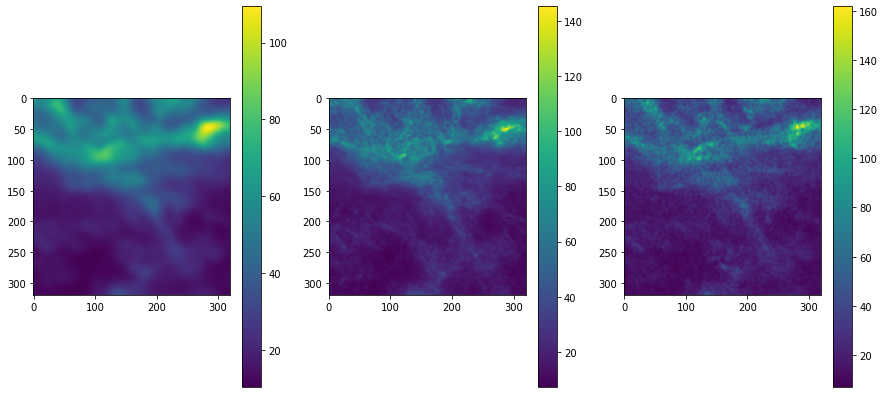

In [13]:
expl = 61
plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(Ls[expl])
plt.colorbar()
plt.subplot(132)
plt.imshow(NN_Ss[expl]*Ls[expl])
plt.colorbar()
plt.subplot(133)
plt.imshow(Ss[expl])
plt.colorbar()

In [40]:
#np.save('/global/homes/k/krach/scratch/NNforFG/maps/patches_NN_dust_T_nside2048_fwhm0.12.npy', NN_Ss*Ls)

In [14]:
NNfin = np.load('/global/homes/k/krach/scratch/NNforFG/maps/patches_NN_dust_T_nside2048_fwhm0.12.npy')

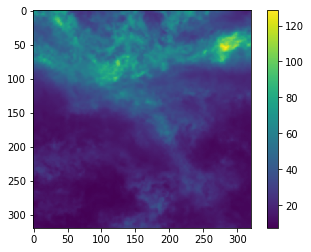

In [15]:
plt.imshow(NNfin[expl])
plt.colorbar()

In [16]:
mapdir = '/global/homes/k/krach/scratch/NNforFG/maps/'
m1 = hp.read_map(mapdir+'PySM_dust_T_nside2048_fwhm1.fits')
m012 = hp.read_map(mapdir+'PySM_dust_T_nside2048_fwhm0.12.fits')
mNN = hp.read_map(mapdir+'PySM_NN_dust_T_nside2048.fits')

/global/homes/k/krach/usr/python_prefix_3.7/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


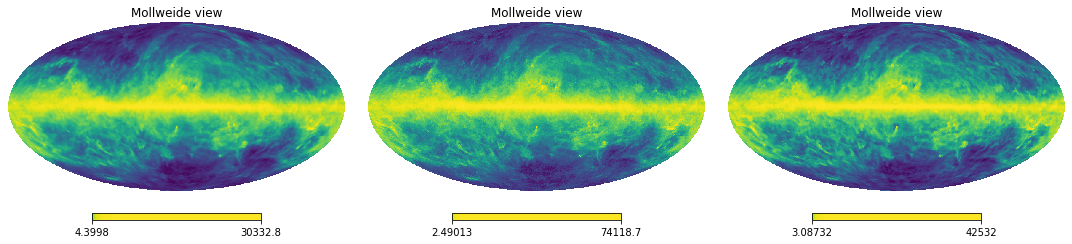

In [17]:
plt.figure(figsize=(15, 6))
hp.mollview(m1, norm='hist', sub=131)
hp.mollview(m012,norm='hist', sub=132)
hp.mollview(mNN, norm='hist', sub=133)

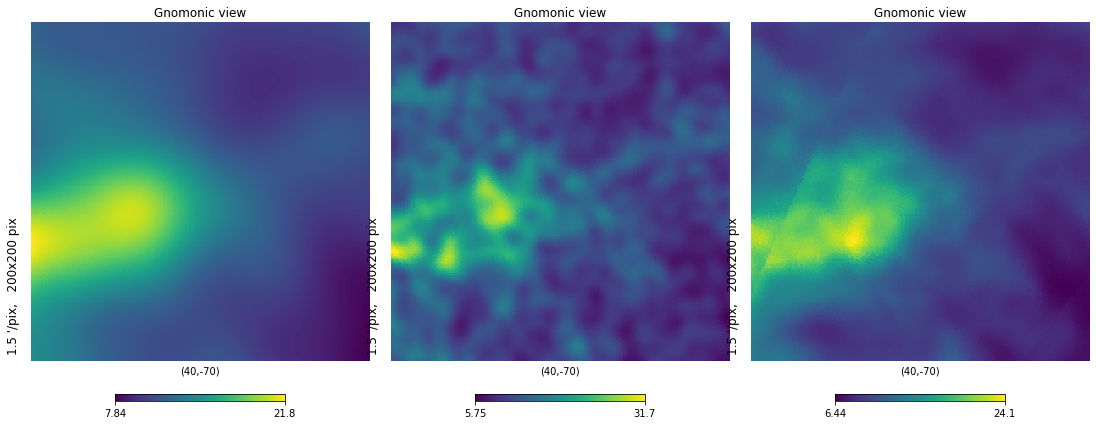

In [18]:
crd = [40, -70]
plt.figure(figsize=(15, 6))
hp.gnomview(m1, sub=131, rot=crd)
hp.gnomview(m012, sub=132, rot=crd)
hp.gnomview(mNN, sub=133, rot=crd)

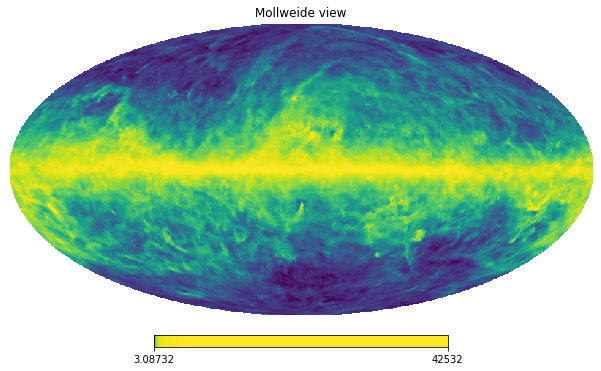

In [19]:
hp.mollview(mNN, norm='hist')